In [1]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *


%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()



Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24569/3556200934.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [2]:

def subset_data(Y, E, G, n_samples=50000, seed=42):
    """
    Subset the data to n_samples individuals while maintaining consistency
    
    Args:
        Y: tensor of shape [N, D, T]
        E: tensor of shape [N, D]
        G: tensor of shape [N, P]
        n_samples: number of individuals to keep
        seed: random seed for reproducibility
    
    Returns:
        Y_sub, E_sub, G_sub: subsetted tensors
    """
    torch.manual_seed(seed)
    
    # Get total number of individuals
    N = Y.shape[0]
    
    # Randomly select n_samples indices
    indices = torch.randperm(N)[:n_samples]
    
    # Subset all matrices using the same indices
    Y_sub = Y[indices]
    E_sub = E[indices]
    G_sub = G[indices]
    
    print(f"Original shapes: Y={Y.shape}, E={E.shape}, G={G.shape}")
    print(f"New shapes: Y={Y_sub.shape}, E={E_sub.shape}, G={G_sub.shape}")
    
    return Y_sub, E_sub, G_sub, indices

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, n_samples=10000,seed=1)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data


Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


In [3]:
# When initializing the model:
original_G = G_100k.clone().detach()  # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24569/685643090.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt'

In [4]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


Signature references shape: torch.Size([20, 52])
Healthy reference shape: torch.Size([52])


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24569/823062432.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('reference_trajectories.pt')

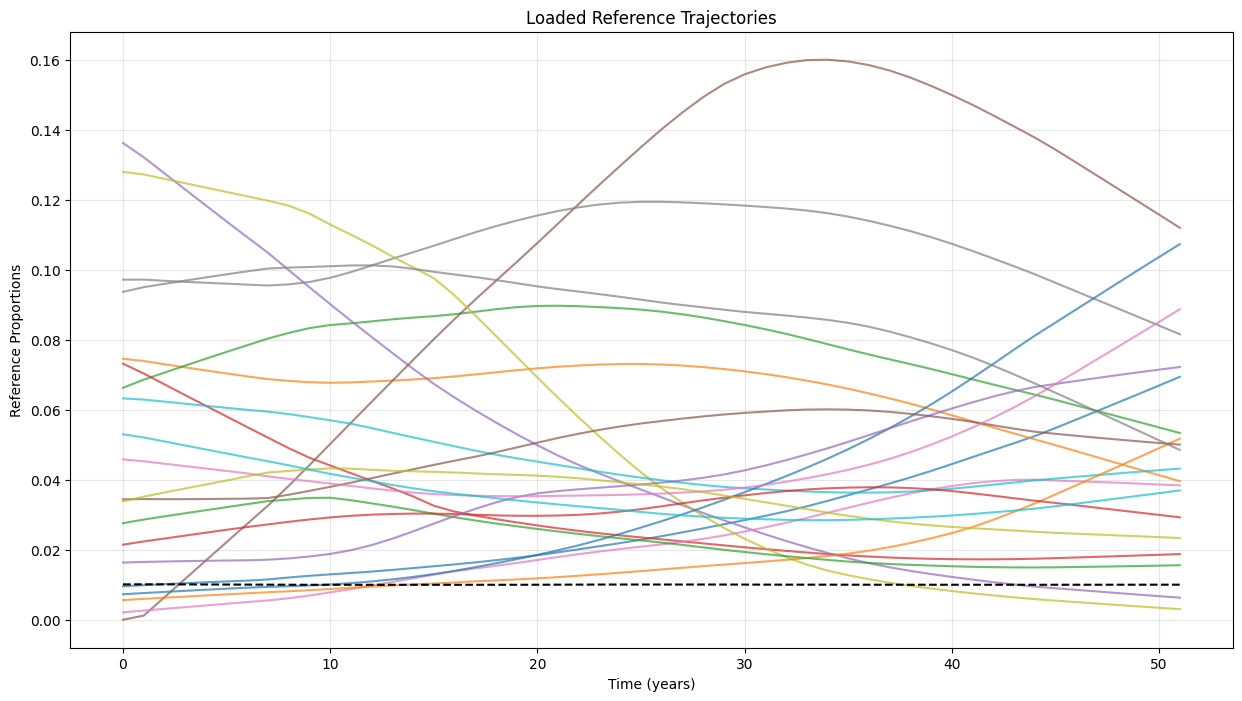

In [5]:
# Load the saved references
refs = torch.load('reference_trajectories.pt')
signature_refs = refs['signature_refs']
healthy_ref = refs['healthy_ref']

# Verify the shapes
print("Signature references shape:", signature_refs.shape)  # Should be [K, T]
print("Healthy reference shape:", healthy_ref.shape)       # Should be [T]

# Optional: Quick plot to verify they loaded correctly
plt.figure(figsize=(15, 8))
props = torch.softmax(torch.vstack([signature_refs, healthy_ref]), dim=0)
for k in range(signature_refs.shape[0]):
    plt.plot(range(len(healthy_ref)), props[k], label=f'Signature {k}', alpha=0.7)
plt.plot(range(len(healthy_ref)), props[-1], label='Healthy', color='black', linestyle='--')
plt.xlabel('Time (years)')
plt.ylabel('Reference Proportions')
plt.title('Loaded Reference Trajectories')
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
# Create model with references
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    G=G_100k, 
    Y=Y_100k,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,
    healthy_reference=healthy_ref,
    disease_names=essentials['disease_names']
)

# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters

# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.healthy_ref = torch.tensor(healthy_reference, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather tha

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 6 diseases
Cluster 2: 13 diseases
Cluster 3: 97 diseases
Cluster 4: 22 diseases
Cluster 5: 22 diseases
Cluster 6: 15 diseases
Cluster 7: 17 diseases
Cluster 8: 35 diseases
Cluster 9: 6 diseases
Cluster 10: 13 diseases
Cluster 11: 9 diseases
Cluster 12: 11 diseases
Cluster 13: 6 diseases
Cluster 14: 17 diseases
Cluster 15: 5 diseases
Cluster 16: 15 diseases
Cluster 17: 8 diseases
Cluster 18: 17 diseases
Cluster 19: 3 diseases
Added healthy cluster
Initialization complete!

Using true psi from simulation plus healthy cluster
Added healthy cluster
Initialization complete!

Clusters match exactly: True


In [8]:
random_diseases = np.random.choice(348, size=5, replace=False)
for idx, d in enumerate(random_diseases):
    state_logits = model.phi[:, d, :].mean(dim=1).detach().numpy()  # Average over time
    print(state_logits)      

[ -9.869387  -10.881876  -10.559867   -7.713949  -12.990282  -10.28062
 -11.7505665 -10.872255  -11.615447  -11.10467   -11.076183   -9.114095
 -10.598768  -12.576882  -11.297883   -9.793112  -10.823358  -12.248606
 -11.624883  -11.477046  -14.509272 ]
[ -8.703759   -9.820205   -9.767523   -8.777305  -10.613785   -7.3075304
  -9.451585   -8.87565   -10.586401  -10.017391   -8.95527   -10.542692
 -11.045125   -7.6573057 -10.235368  -10.740503   -8.627352   -9.698882
  -8.515145   -9.035021  -11.605679 ]
[-10.822791  -11.128135  -10.002336  -10.435331  -11.063806   -9.547184
  -9.662738   -7.3729396  -9.812593   -9.602093   -9.643463   -9.750533
 -10.591141  -10.489982   -9.161737   -8.841277  -11.734516   -9.732935
 -10.142124  -10.570541  -14.262463 ]
[-11.990432 -12.263818 -12.421642 -11.766328 -12.358227 -11.95053
 -13.98211  -12.931929 -10.168474 -11.469082 -11.854399 -12.687899
 -11.327849 -11.066244 -11.731807 -12.151237 -12.56851  -12.174868
 -11.853194 -13.154454 -15.790929]
[-1

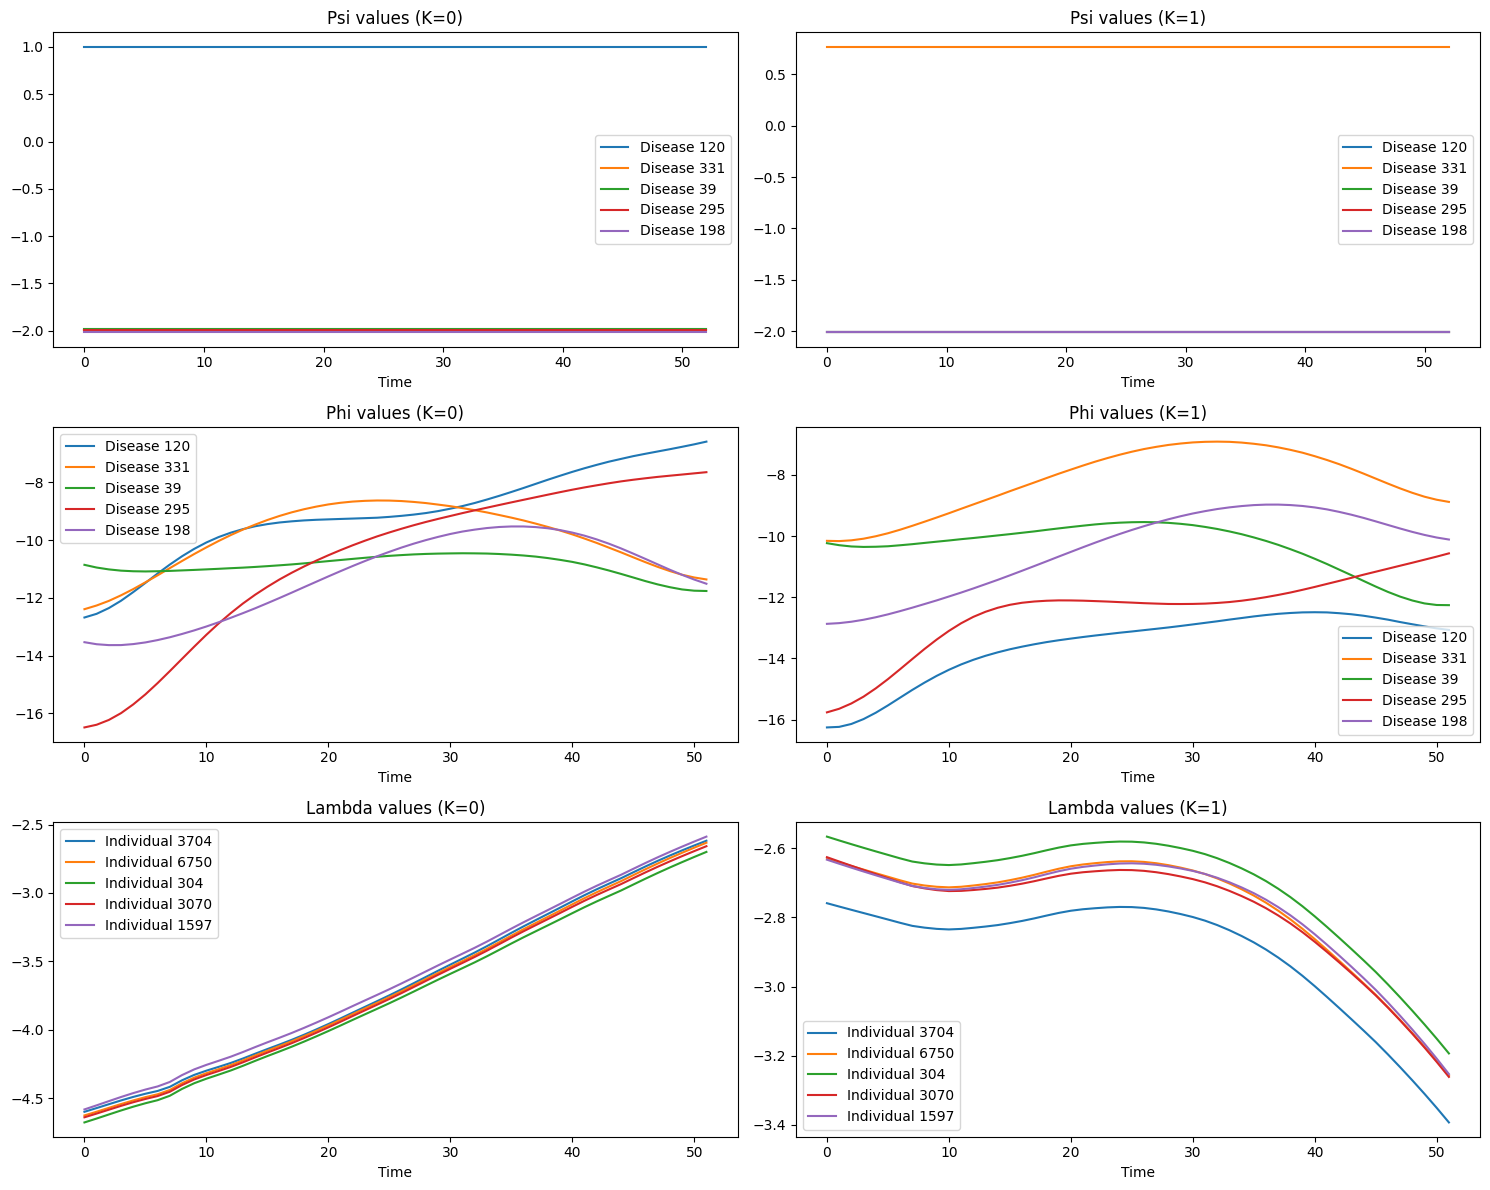


Cluster membership for sampled diseases:
Disease 120: Cluster 0
Disease 331: Cluster 1
Disease 39: Cluster 19
Disease 295: Cluster 16
Disease 198: Cluster 17

Cluster Assignments:

Cluster 0:
  - Rheumatic disease of the heart valves (prevalence: 0.0002)
  - Mitral valve disease (prevalence: 0.0003)
  - Aortic valve disease (prevalence: 0.0001)
  - Disease of tricuspid valve (prevalence: 0.0003)
  - Other forms of chronic heart disease (prevalence: 0.0004)
  - Cardiomegaly (prevalence: 0.0005)
  - Pericarditis (prevalence: 0.0001)
  - Primary/intrinsic cardiomyopathies (prevalence: 0.0001)
  - Left bundle branch block (prevalence: 0.0003)
  - Paroxysmal supraventricular tachycardia (prevalence: 0.0002)
  - Paroxysmal ventricular tachycardia (prevalence: 0.0001)
  - Atrial fibrillation and flutter (prevalence: 0.0009)
  - Congestive heart failure (CHF) NOS (prevalence: 0.0003)
  - Heart failure NOS (prevalence: 0.0007)
  - Pleurisy; pleural effusion (prevalence: 0.0008)
  - Congenital 

In [9]:
model.plot_initial_params()
model.visualize_clusters(disease_names=essentials['disease_names'])

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:792: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


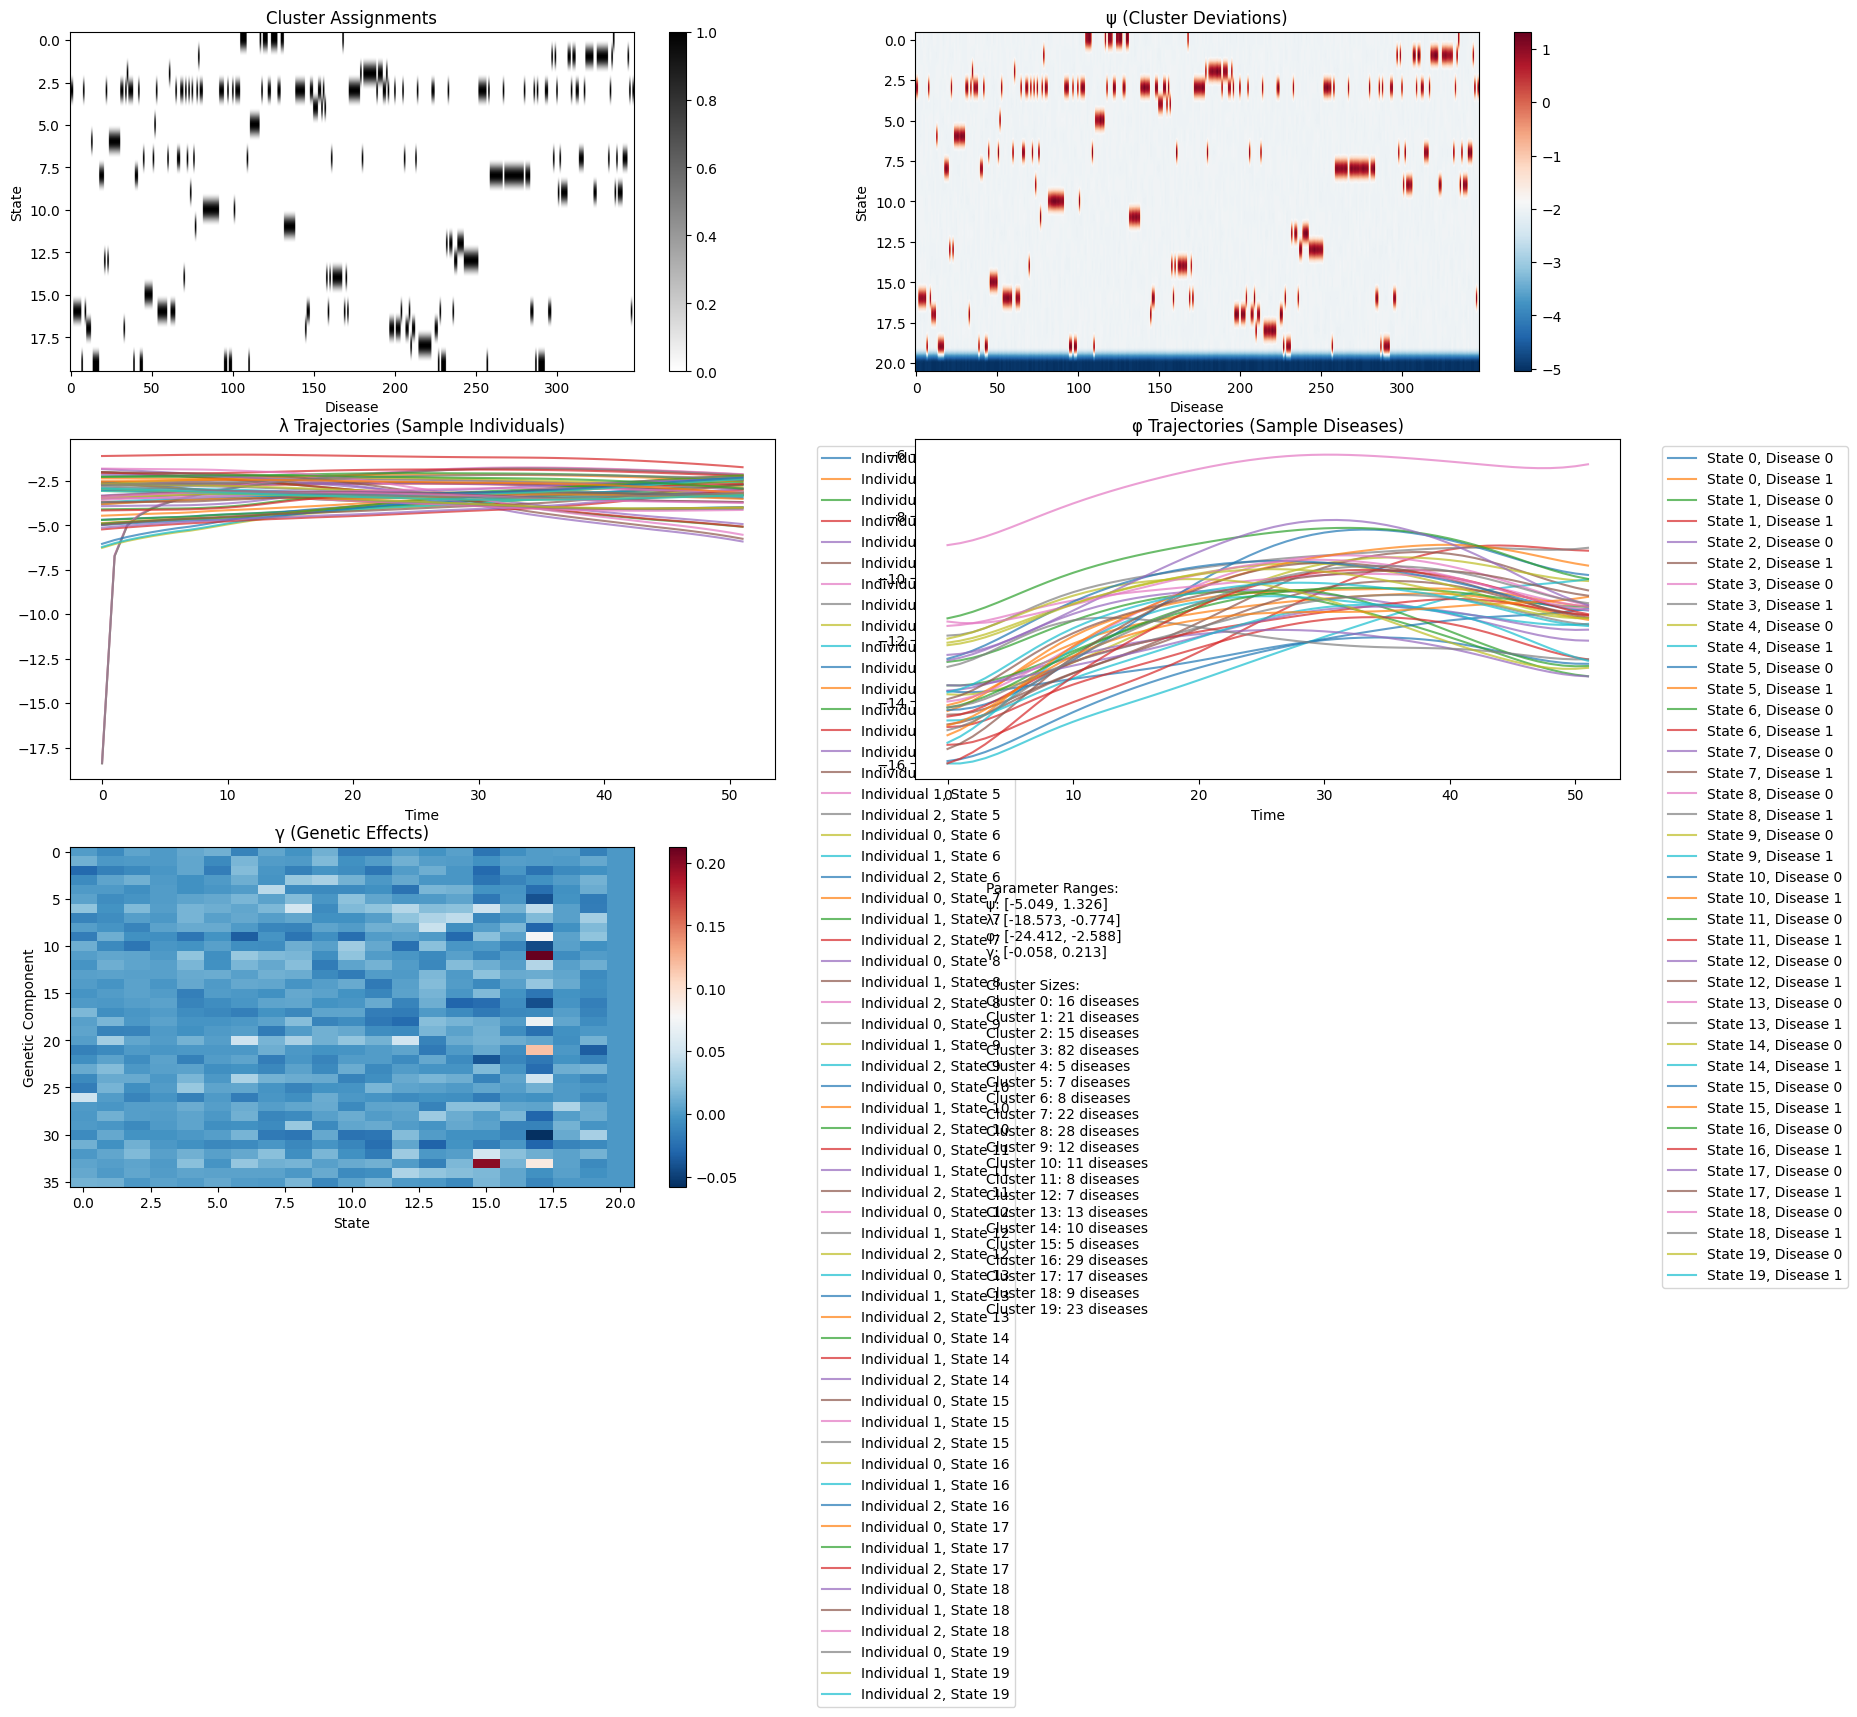

In [30]:
model.visualize_initialization()

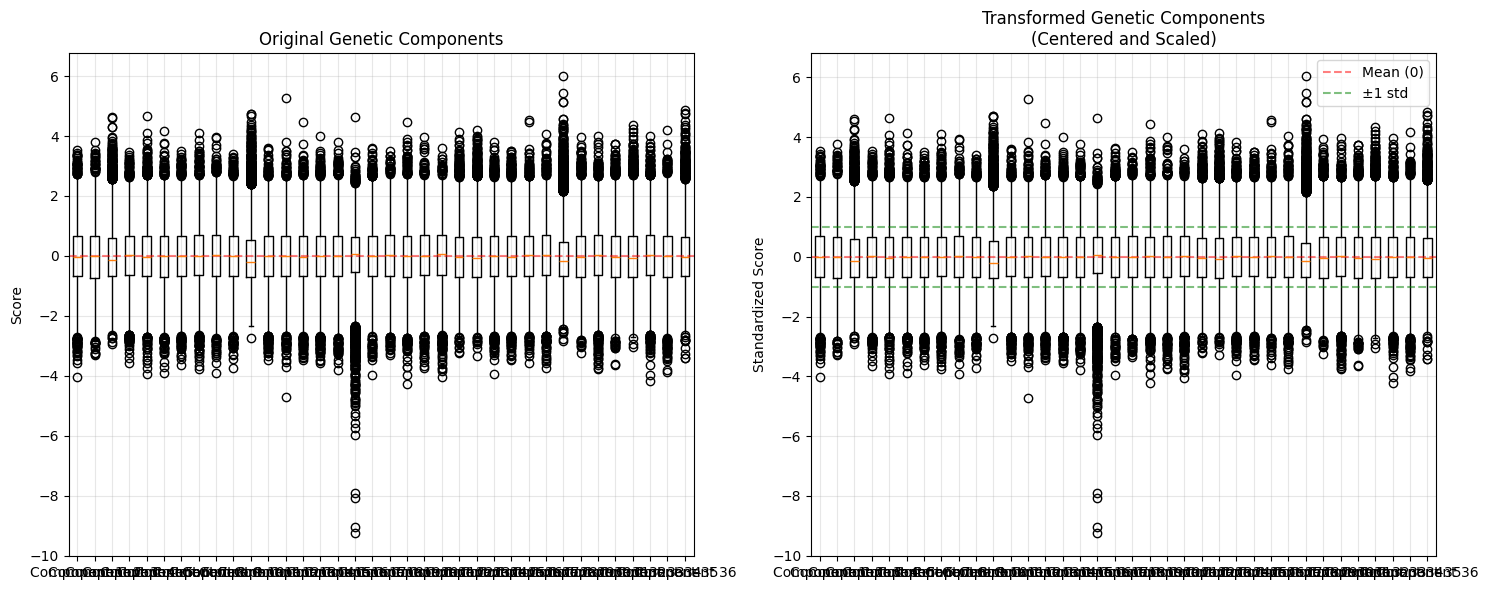


Genetic Components Summary Statistics:
Component  Original Mean Original Std  Trans. Mean  Trans. Std
------------------------------------------------------------
1                 -0.007        1.004       -0.000       1.000
2                 -0.001        1.011       -0.000       1.000
3                  0.018        1.005       -0.000       1.000
4                  0.009        0.977       -0.000       1.000
5                  0.000        1.005        0.000       1.000
6                 -0.013        1.007        0.000       1.000
7                  0.012        1.001       -0.000       1.000
8                  0.012        1.001       -0.000       1.000
9                  0.017        1.006        0.000       1.000
10                 0.010        1.001        0.000       1.000
11                 0.013        1.002       -0.000       1.000
12                 0.005        0.998        0.000       1.000
13                -0.001        0.998        0.000       1.000
14               

In [10]:

# Plot both versions:
model.plot_genetic_scores(original_G)
print(model.G[:,3].mean())

print(original_G[:,3].mean())


# Check G matrix scaling
G_mean = model.G.mean(dim=0)
G_std = model.G.std(dim=0)
print("\nG matrix scaling check:")
print(f"Mean should be ~0: {G_mean.abs().max().item():.6f}")
print(f"Std should be ~1: {(G_std - 1).abs().max().item():.6f}")


In [11]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()


In [12]:

history_new = model.fit(E_100k, num_epochs=300, learning_rate=1e-2, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:194: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 612.4154
Psi gradient stats:
Mean: 2.2896e-05
Std:  4.7578e-03
Max:  1.7272e-02
Min:  -1.9490e-02
Epoch 0, Loss: 612.4154, Gradients - Lambda: 5.288e-03, Phi: 1.375e+01, Gamma: 6.247e-04, Psi: 1.949e-02
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 1
Loss: 539.7573
Psi gradient stats:
Mean: 2.3385e-05
Std:  4.7515e-03
Max:  1.7315e-02
Min:  -1.9501e-02
Epoch 1, Loss: 539.7573, Gradients - Lambda: 4.217e-02, Phi: 1.321e+01, Gamma: 9.912e-04, Psi: 1.950e-02

Estimated total training time: 162.7 minutes
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 2
Loss: 468.2329
Psi gradient stats:
Mean: 2.3712e-05
Std:  4.7455e-03
Max:  1.7360e-02
Min:  -1.9513e-02
Epoch 2, Loss: 468.2329, Gradients - Lambda: 2.641e-02, Phi: 1.266e+01, Gamma: 1.345e-03, Psi

In [13]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-4:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-4:
Mean absolute change: 4.396e-05
Max absolute change: 8.767e-03
Std of changes: 4.775e-05


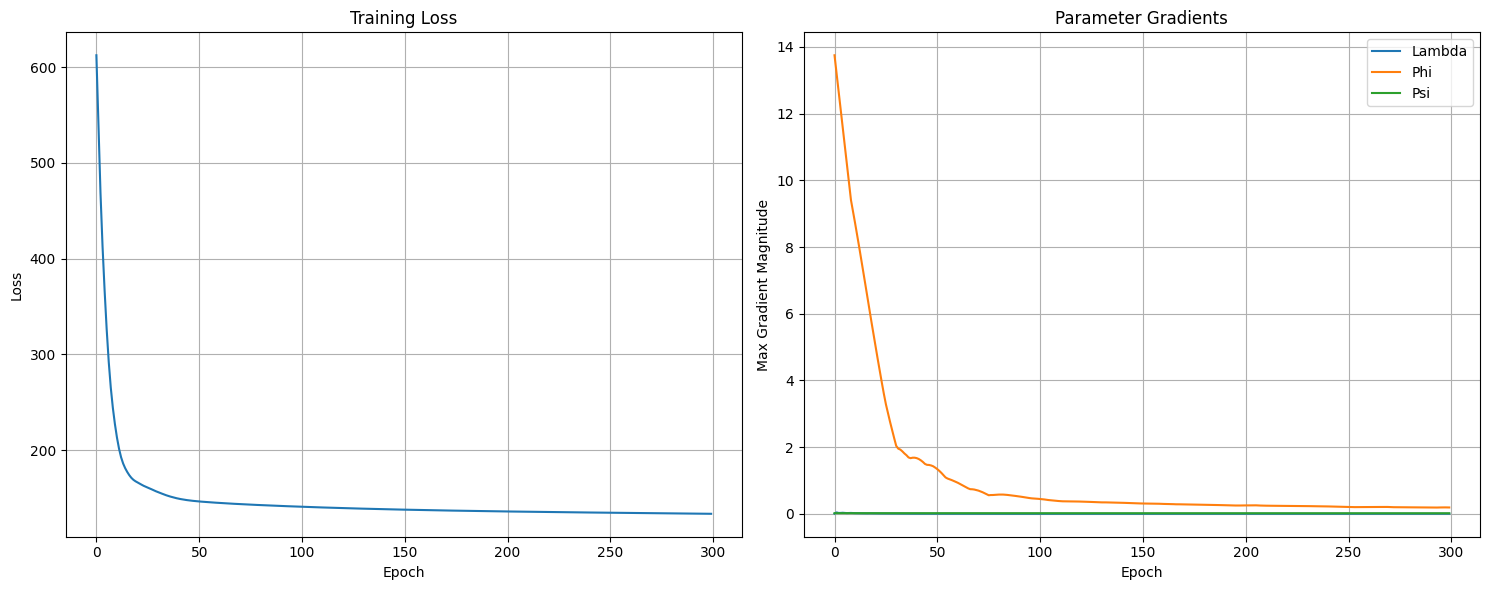

In [14]:

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history_new['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history_new['max_grad_lambda'], label='Lambda')
ax2.plot(history_new['max_grad_phi'], label='Phi')
ax2.plot(history_new['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Starting analysis...
Found 5 CV conditions
Found 6 cancer conditions
Found 4 metabolic conditions
Processed 0 patients...
Processed 1000 patients...
Processed 2000 patients...
Processed 3000 patients...
Processed 4000 patients...
Processed 5000 patients...
Processed 6000 patients...
Processed 7000 patients...
Processed 8000 patients...
Processed 9000 patients...

Found 10000 interesting cases

Plotting top 5 cases...


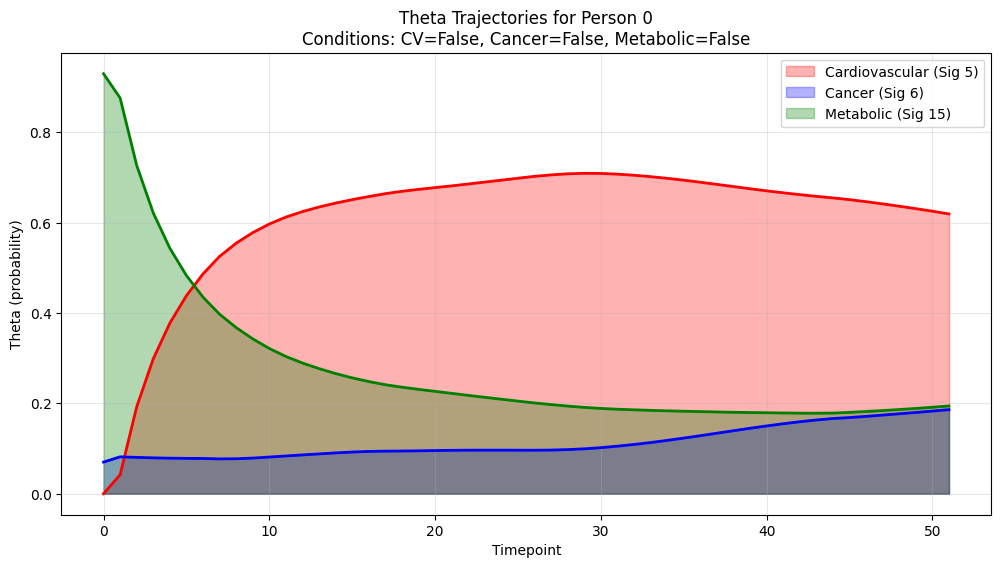

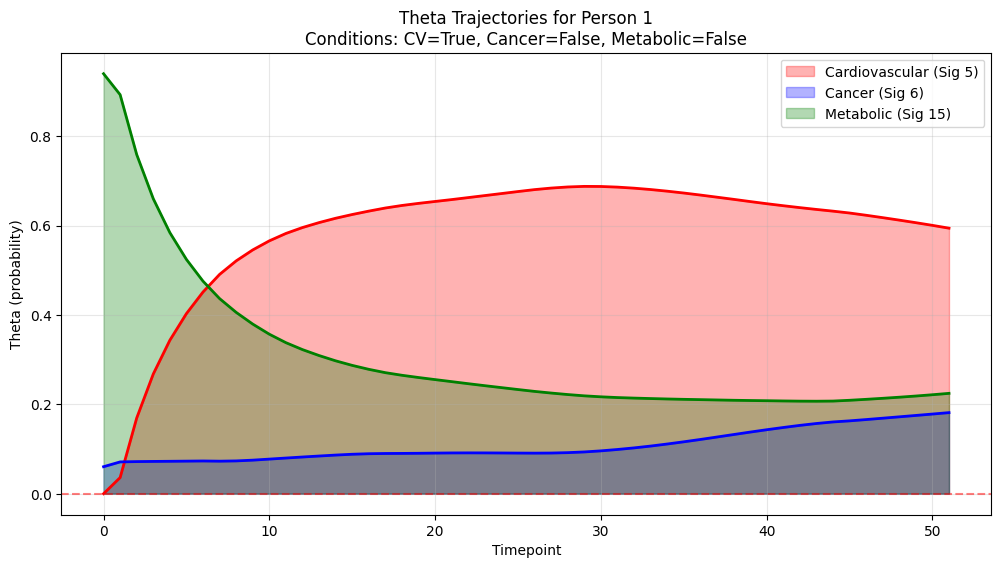

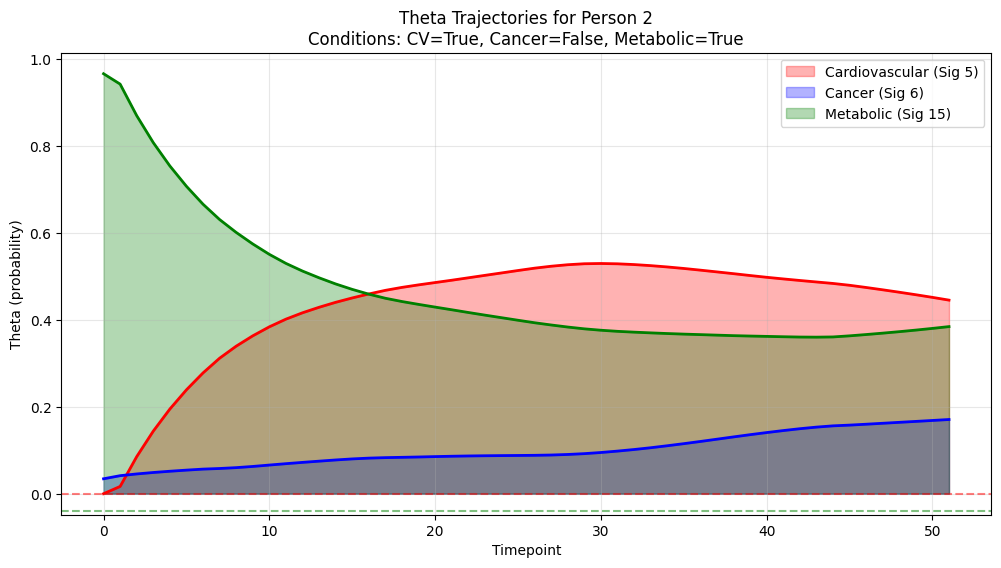

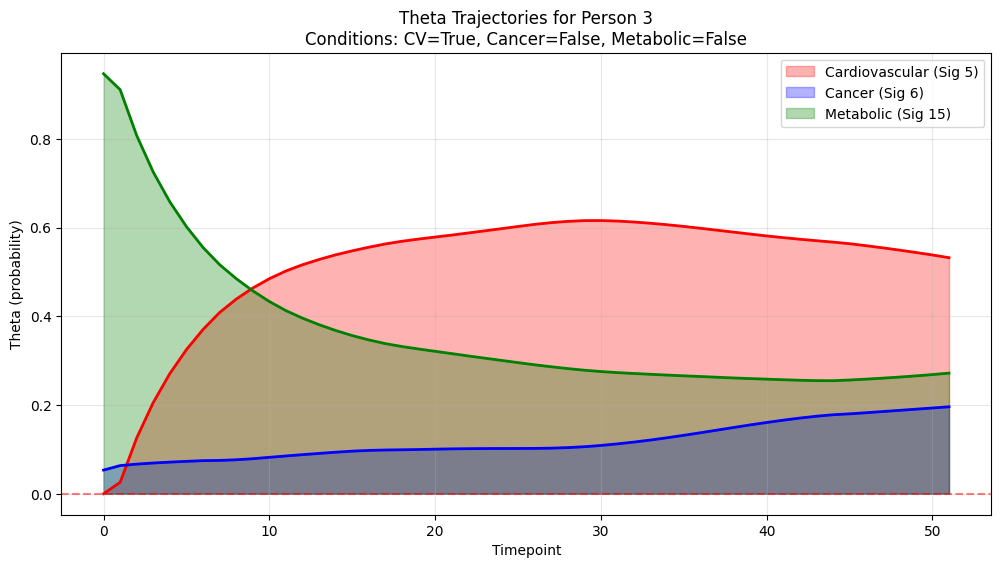

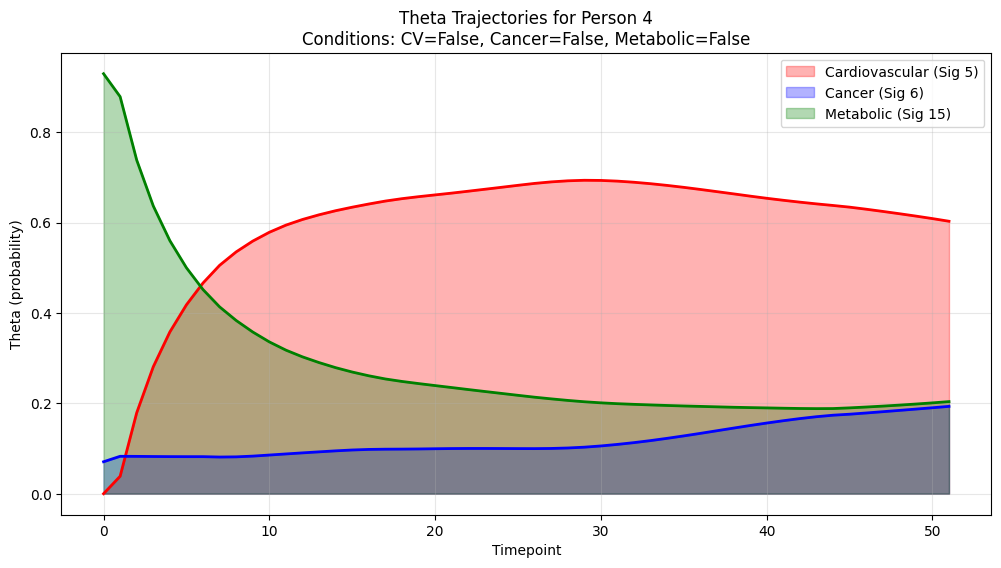

In [33]:
SIGNATURE_CONDITIONS  = {
    'Cardiovascular (5)': [
        'Coronary atherosclerosis',
        'Other chronic ischemic heart disease, unspecified',
        'Myocardial infarction',
        'Hypercholesterolemia',
        'Angina pectoris'
    ],
    
    'Cancer (6)': [
        'Secondary malignancy of bone',
        'Secondary malignant neoplasm of digestive systems',
        'Cancer of bronchus; lung',
        'Secondary malignancy of lymph nodes',
        'Secondary malignant neoplasm'
    ],
    
    'Metabolic (15)': [
        'Type 2 diabetes',
        'Hypoglycemia',
        'Type 2 diabetes with ophthalmic manifestations',
        'Diabetic retinopathy'
    ]
}


# 1. Make sure we have all necessary imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

def find_transition_patients(lambdas, Y, disease_names):
    """
    Find patients who show clear transitions between signatures
    """
    # Convert lambdas to torch tensor if it's numpy array
    if isinstance(lambdas, np.ndarray):
        lambdas = torch.from_numpy(lambdas).float()
    
    # Convert Y to torch tensor if needed
    if isinstance(Y, np.ndarray):
        Y = torch.from_numpy(Y).float()
        
    # Get indices for conditions we care about
    cv_indices = [i for i, name in enumerate(disease_names) 
                 if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Cardiovascular (5)'])]
    cancer_indices = [i for i, name in enumerate(disease_names) 
                     if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Cancer (6)'])]
    metabolic_indices = [i for i, name in enumerate(disease_names) 
                        if any(cond in str(name) for cond in SIGNATURE_CONDITIONS['Metabolic (15)'])]
    
    print(f"Found {len(cv_indices)} CV conditions")
    print(f"Found {len(cancer_indices)} cancer conditions")
    print(f"Found {len(metabolic_indices)} metabolic conditions")
    
    interesting_cases = []
    
    for pid in range(len(Y)):
        # Get trajectories for signatures 5, 6, and 15
        trajectories = lambdas[pid, [5,6,15], :].float()  # Shape: [3, 52]
        
        # Apply softmax to get probabilities
        trajectories = torch.stack([softmax(trajectories[:, t], dim=0) 
                                  for t in range(trajectories.shape[1])], dim=1)
        
        # Check if they have any of the conditions
        has_cv = torch.any(Y[pid, cv_indices]).item() if len(cv_indices) > 0 else False
        has_cancer = torch.any(Y[pid, cancer_indices]).item() if len(cancer_indices) > 0 else False
        has_metabolic = torch.any(Y[pid, metabolic_indices]).item() if len(metabolic_indices) > 0 else False
        
        # Look for significant changes in signature strengths
        sig_changes = (trajectories.max(dim=1)[0] - trajectories.min(dim=1)[0])
        
        if torch.max(sig_changes) > 0.3:  # Threshold for interesting change
            interesting_cases.append({
                'pid': pid,
                'trajectories': trajectories.detach().cpu().numpy(),
                'conditions': {
                    'cv': has_cv,
                    'cancer': has_cancer,
                    'metabolic': has_metabolic
                }
            })
            
        if pid % 1000 == 0:
            print(f"Processed {pid} patients...")
    
    return interesting_cases

def plot_theta_trajectories(case):
    """
    Plot signature trajectories for a case
    """
    plt.figure(figsize=(12, 6))
    
    t = np.arange(52)
    trajectories = case['trajectories']
    
    # Plot filled curves
    plt.fill_between(t, 0, trajectories[0], alpha=0.3, color='red', label='Cardiovascular (Sig 5)')
    plt.fill_between(t, 0, trajectories[1], alpha=0.3, color='blue', label='Cancer (Sig 6)')
    plt.fill_between(t, 0, trajectories[2], alpha=0.3, color='green', label='Metabolic (Sig 15)')
    
    # Plot lines
    plt.plot(t, trajectories[0], color='red', linewidth=2)
    plt.plot(t, trajectories[1], color='blue', linewidth=2)
    plt.plot(t, trajectories[2], color='green', linewidth=2)
    
    # Add diagnosis indicators
    y_min = 0
    if case['conditions']['cv']:
        plt.axhline(y=y_min, color='red', linestyle='--', alpha=0.5)
    if case['conditions']['cancer']:
        plt.axhline(y=y_min-0.02, color='blue', linestyle='--', alpha=0.5)
    if case['conditions']['metabolic']:
        plt.axhline(y=y_min-0.04, color='green', linestyle='--', alpha=0.5)
    
    plt.title(f'Theta Trajectories for Person {case["pid"]}\n' + 
             f'Conditions: CV={case["conditions"]["cv"]}, Cancer={case["conditions"]["cancer"]}, ' +
             f'Metabolic={case["conditions"]["metabolic"]}')
    plt.xlabel('Timepoint')
    plt.ylabel('Theta (probability)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

# Run the analysis
print("Starting analysis...")
cases = find_transition_patients(model.lambda_, Y_100k, essentials['disease_names'])
print(f"\nFound {len(cases)} interesting cases")

# Plot results
if len(cases) > 0:
    print("\nPlotting top 5 cases...")
    for case in cases[:5]:
        plot_theta_trajectories(case)
        plt.show()

In [ ]:
# First get the trained parameters from your existing model
pretrained_phi = model.phi.detach().clone()
pretrained_gamma = model.gamma.detach().clone()
pretrained_psi = model.psi.detach().clone()

# Get a new batch of 10k individuals
Y_new, E_new, G_new, new_indices = subset_data(Y, E, G, n_samples=10000, seed=43)  # Using different seed


In [ ]:
from gp_clust_pretrained import *
%load_ext autoreload
%autoreload 2


# Create pretrained model for new data
pretrained_model = AladynSurvivalPretrainedModel(
    N=Y_new.shape[0],  # 10000
    D=Y_new.shape[1],  # same number of diseases
    T=Y_new.shape[2],  # same time points
    K=essentials['K'],  # same number of clusters
    P=essentials['P'],  # same number of genetic components
    G=G_new,           # genetic data for new individuals
    Y=Y_new,           # outcome data for new individuals
    prevalence_t=essentials['prevalence_t'],  # same prevalence
    pretrained_phi=pretrained_phi,
    pretrained_gamma=pretrained_gamma,
    pretrained_psi=pretrained_psi
)


In [ ]:

# Fit only lambda parameters for new individuals
history_new = pretrained_model.fit(E_new, num_epochs=100, learning_rate=1e-3)



In [ ]:

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history_new['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history_new['max_grad_lambda'], label='Lambda')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [20]:
disease_names=essentials['disease_names']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert gamma tensors to numpy arrays
initial_gamma_np = initial_gamma.detach().numpy()
final_gamma_np = model.gamma.detach().numpy()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial gamma
sns.heatmap(initial_gamma_np, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Gamma')

# Plot final gamma
sns.heatmap(final_gamma_np, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Gamma')

# Add a title to the figure
plt.suptitle('Comparison of Initial vs Final Gamma Values', fontsize=16)

# You can also add a colorbar
plt.tight_layout()

# To see the actual difference, you can also create a difference heatmap
plt.figure(figsize=(10, 8))
diff = final_gamma_np - initial_gamma_np
sns.heatmap(diff, cmap='RdBu_r', center=0)
plt.title('Difference (Final - Initial Gamma)')
plt.show()

# Print some summary statistics
print(f"Mean absolute difference: {np.abs(diff).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff):.4f}")

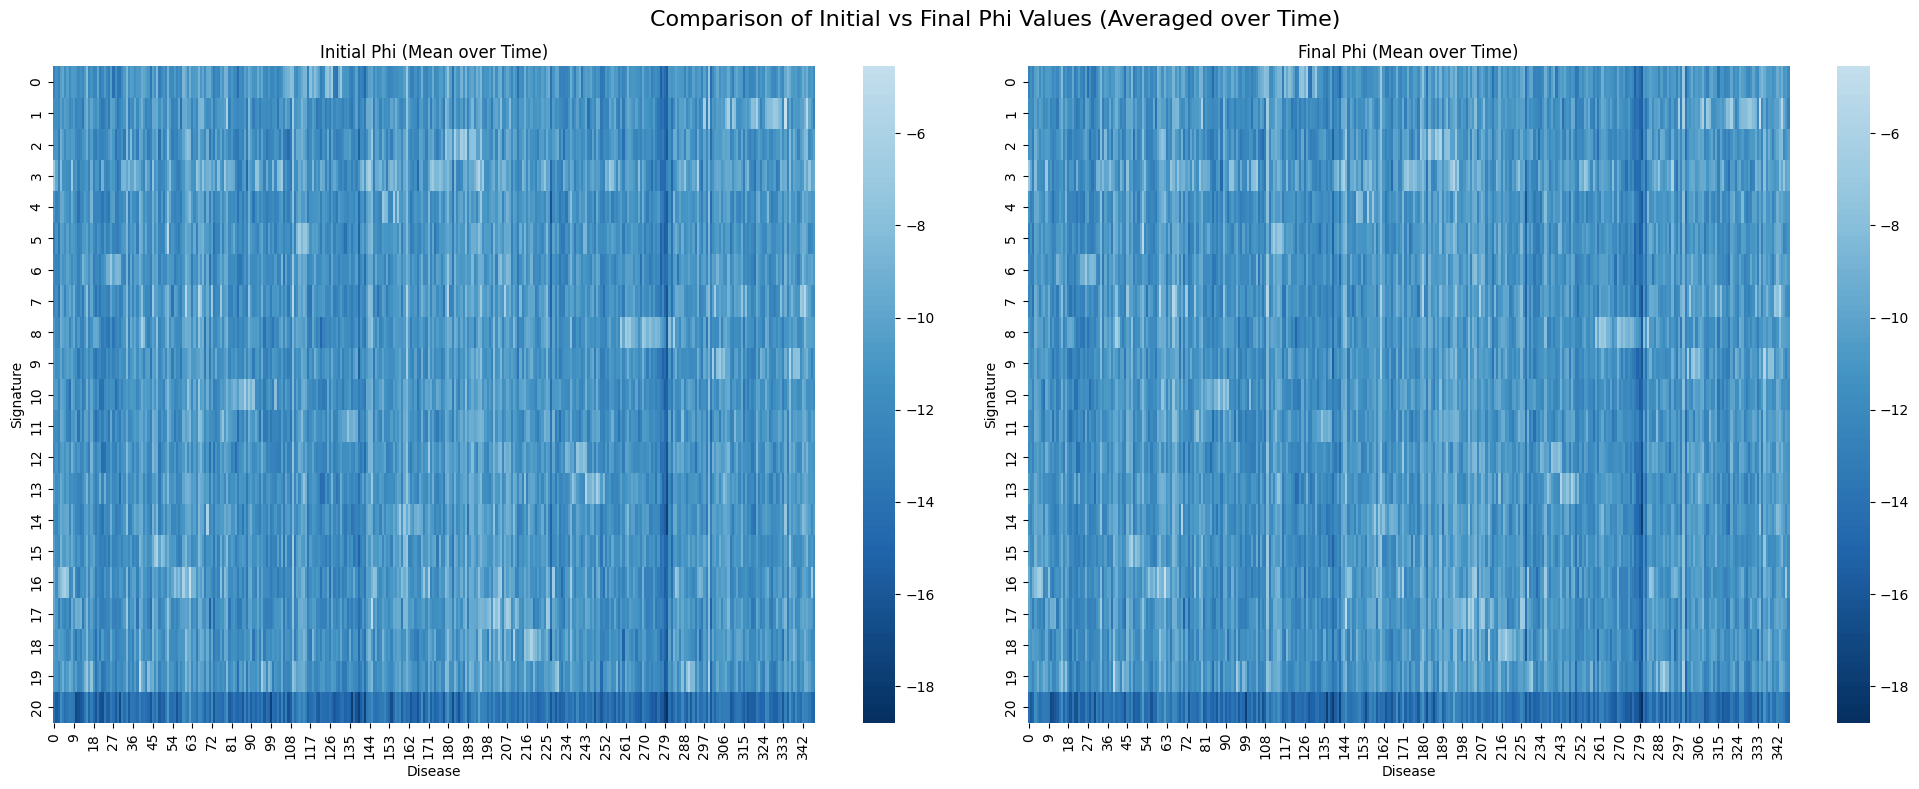

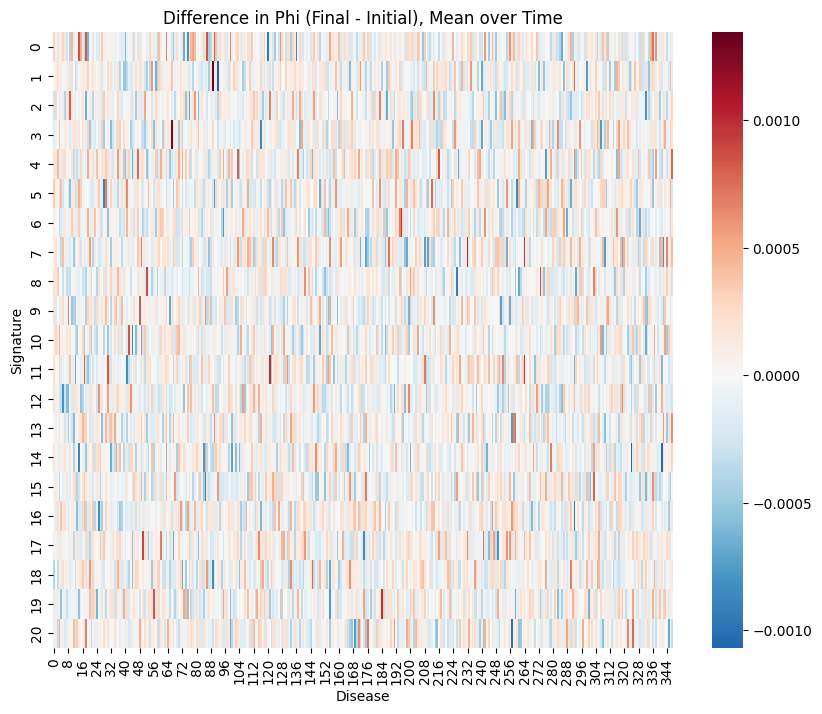

Full tensor statistics:
Mean absolute difference: 0.0015
Max absolute difference: 0.0245
Standard deviation of differences: 0.0020

Time-averaged statistics:
Mean absolute difference: 0.0002
Max absolute difference: 0.0013
Standard deviation of differences: 0.0002


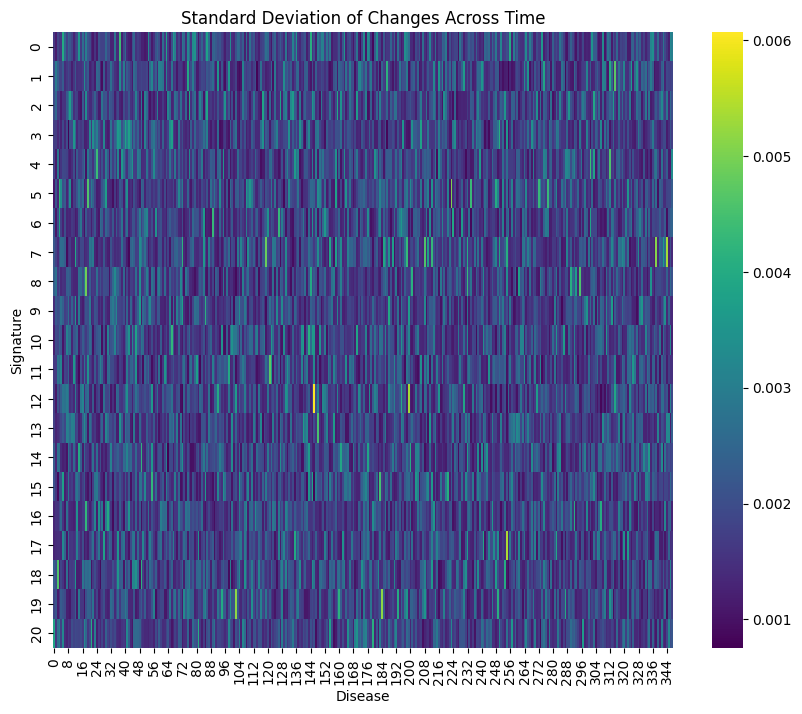

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert phi tensors to numpy arrays
initial_phi_np = initial_phi.detach().numpy()  # Shape: (K, D, T)
final_phi_np = model.phi.detach().numpy()

# Take mean over time dimension
initial_phi_mean = initial_phi_np.mean(axis=2)  # Shape: (K, D)
final_phi_mean = final_phi_np.mean(axis=2)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial phi (averaged over time)
sns.heatmap(initial_phi_mean, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Phi (Mean over Time)')
ax1.set_xlabel('Disease')
ax1.set_ylabel('Signature')

# Plot final phi (averaged over time)
sns.heatmap(final_phi_mean, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Phi (Mean over Time)')
ax2.set_xlabel('Disease')
ax2.set_ylabel('Signature')

plt.suptitle('Comparison of Initial vs Final Phi Values (Averaged over Time)', fontsize=16)
plt.tight_layout()

# Plot difference
plt.figure(figsize=(10, 8))
diff_mean = final_phi_mean - initial_phi_mean
sns.heatmap(diff_mean, cmap='RdBu_r', center=0)
plt.title('Difference in Phi (Final - Initial), Mean over Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

# Print summary statistics for both full tensor and time-averaged differences
print("Full tensor statistics:")
diff_full = final_phi_np - initial_phi_np
print(f"Mean absolute difference: {np.abs(diff_full).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_full).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_full):.4f}")

print("\nTime-averaged statistics:")
print(f"Mean absolute difference: {np.abs(diff_mean).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_mean).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_mean):.4f}")

# Optionally, look at temporal variation
temporal_std = np.std(diff_full, axis=2)
plt.figure(figsize=(10, 8))
sns.heatmap(temporal_std, cmap='viridis')
plt.title('Standard Deviation of Changes Across Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

In [16]:
Y_global=Y


In [ ]:
Y_global.shape

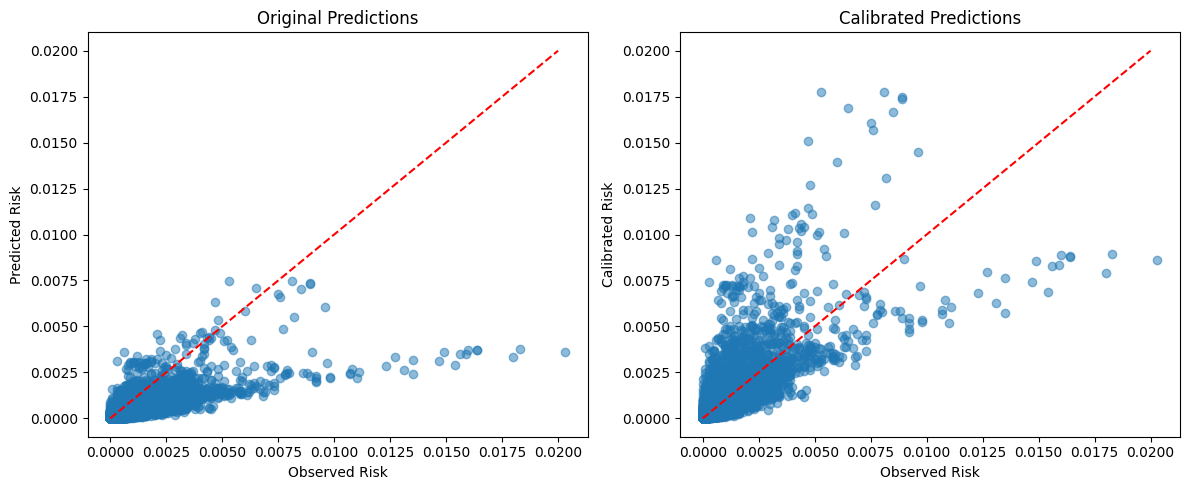

Mean observed risk: 0.000439
Mean predicted risk (original): 0.000184
Mean predicted risk (calibrated): 0.000439
Calibration scale factor: 2.379


In [16]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [35]:
model.visualize_clusters(disease_names=essentials['disease_names'])


Cluster Assignments:

Cluster 0:
  - Rheumatic disease of the heart valves (prevalence: 0.0002)
  - Mitral valve disease (prevalence: 0.0003)
  - Aortic valve disease (prevalence: 0.0001)
  - Disease of tricuspid valve (prevalence: 0.0003)
  - Other forms of chronic heart disease (prevalence: 0.0004)
  - Cardiomegaly (prevalence: 0.0005)
  - Pericarditis (prevalence: 0.0001)
  - Primary/intrinsic cardiomyopathies (prevalence: 0.0001)
  - Left bundle branch block (prevalence: 0.0003)
  - Paroxysmal supraventricular tachycardia (prevalence: 0.0002)
  - Paroxysmal ventricular tachycardia (prevalence: 0.0001)
  - Atrial fibrillation and flutter (prevalence: 0.0009)
  - Congestive heart failure (CHF) NOS (prevalence: 0.0003)
  - Heart failure NOS (prevalence: 0.0007)
  - Pleurisy; pleural effusion (prevalence: 0.0008)
  - Congenital anomalies of great vessels (prevalence: 0.0003)

Cluster 1:
  - Other peripheral nerve disorders (prevalence: 0.0009)
  - Rheumatoid arthritis (prevalence: 0.0

In [17]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.472


In [18]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Disease of tricuspid valve: effect=2.508 (OR=12.28), std=0.565
Left bundle branch block: effect=2.102 (OR=8.19), std=0.560
Other forms of chronic heart disease: effect=2.042 (OR=7.71), std=0.949
Atrial fibrillation and flutter: effect=1.794 (OR=6.02), std=0.474
Congenital anomalies of great vessels: effect=1.766 (OR=5.85), std=0.775
Paroxysmal ventricular tachycardia: effect=1.605 (OR=4.98), std=0.742
Paroxysmal supraventricular tachycardia: effect=1.477 (OR=4.38), std=0.687
Heart failure NOS: effect=1.472 (OR=4.36), std=0.228
Cardiomegaly: effect=1.089 (OR=2.97), std=0.179
Rheumatic disease of the heart valves: effect=1.075 (OR=2.93), std=0.327

Top 10 diseases in Signature 1 (relative to baseline):
Pain in joint: effect=2.940 (OR=18.93), std=0.443
Other disorders of synovium, tendon, and bursa: effect=2.700 (OR=14.89), std=0.780
Symptoms and disorders of the joints: effect=2.627 (OR=13.84), std=0.355
Hammer toe (acquired): effec

In [19]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Heart failure NOS: 1.178
2. Aortic valve disease: 1.147
3. Paroxysmal ventricular tachycardia: 1.132
4. Left bundle branch block: 1.103
5. Congestive heart failure (CHF) NOS: 1.073
6. Atrial fibrillation and flutter: 1.055
7. Pericarditis: 1.033
8. Cardiomegaly: 1.027
9. Congenital anomalies of great vessels: 1.005
10. Disease of tricuspid valve: 0.956

Final top diseases:
1. Disease of tricuspid valve: 2.508
2. Left bundle branch block: 2.102
3. Other forms of chronic heart disease: 2.042
4. Atrial fibrillation and flutter: 1.794
5. Congenital anomalies of great vessels: 1.766
6. Paroxysmal ventricular tachycardia: 1.605
7. Paroxysmal supraventricular tachycardia: 1.477
8. Heart failure NOS: 1.472
9. Cardiomegaly: 1.089
10. Rheumatic disease of the heart valves: 1.075

Congestive heart failure (CHF) NOS changed from rank 5 to 12

Heart failure NOS changed from rank 1 to 8

Congenital anomalies of great vessels changed from rank 9 to 5

Aortic va

In [ ]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:
disease_names=essentials['disease_names']
plot_signature_temporal_patterns(model, disease_names, selected_signatures=[0,1,14,15,16,13,17])

In [35]:
Y_avg_global = torch.mean(torch.tensor(Y) if isinstance(Y,np.ndarray) else Y, dim=2)
Y_avg_batch = torch.mean(torch.tensor(Y_100k) if isinstance(Y_100k, np.ndarray) else Y_100k, dim=2)


In [ ]:
def compare_disease_patterns(k, true_psi, Y_avg_global, Y_avg_batch):
    """Compare disease patterns between global and batch data"""
    strong_diseases = (true_psi[k] > 0)
    
    # Get mean pattern for each dataset (average across patients)
    pattern_large = Y_avg_global[:, strong_diseases].mean(dim=0)  # Average across all patients
    pattern_small = Y_avg_batch[:, strong_diseases].mean(dim=0)  # Average across batch patients
    
    # Now both patterns are just length of strong_diseases
    correlation = torch.corrcoef(
        torch.stack([pattern_large, pattern_small])
    )[0,1]
    
    print(f"Signature {k} pattern correlation: {correlation:.3f}")
    print(f"Mean pattern difference: {(pattern_large - pattern_small).abs().mean():.3f}")

# Now use it
print("Comparing disease sharing patterns between global and batch data:")
for k in range(model.K):
    print(f"\nSignature {k}:")
    compare_disease_patterns(k, model.psi, Y_avg_global, Y_avg_batch)